---
    Author: Michael Pye (pye.michael@epa.gov) 
    Document created: 05/02/2025  
    Document completed: 05/09/2025  
---

# CMAQ Evaluation with Aircraft Observations Tutorial
On occasion, it is beneficial to compare the output of a CMAQ simulation to observations from aircraft. However, since airplanes have a nasty habit of moving around, it can make comparing the model output to the observations challenging. To address this issue, the CMAQ Flight Pairing Jupyter Notebook was created. The functions within the notebook allow the user to match the location of the aircraft to the nearest CMAQ model grid point. The model values at each grid point that gets matched can then be turned into a vector containing CMAQ data that corresponds directly to the aircraft observations. This notebook details how to use the CMAQ Flight Pairing Jupyter Notebook as well as other files designed to work with it to compare CMAQ output to aircraft observations. 

If more information on a function is needed that what is provided in this tutorial, go directly to the notebook where the function is defined. There is additional description provided there and you will find additional customization options listed there as this tutorial does not cover all possibilities for every function. 

It should also be noted that these notebooks and this tutorial were designed assuming the user is working on the U.S. Environmental Protection Agency's Atmos server. If this is not you, you should still be able to get the tool to work. However, it may involve rewriting some of the code to make sure the file paths are set up correctly for your environment. 

## Imports
The first step is to import all the Python packages. The main packages that will be needed for pairing flight data are:

* `cmaq_flight_pairing`: Package designed to work with any set of aircraft observations and pair them to CMAQ output data so the observations can be compared to the closest model forecasts.
* `aeromma_cmaq_pairing`: Package desiged to take care of flight pairing and analysis tasks specific to data from the 2023 AEROMMA field campaign. It performs preprocessing steps to get the AEROMMA data ready for the observation to CMAQ pairing performed by the `cmaq_flight_pairing` functions as well as post processing steps to extract AEROMMA data in specific ways, clean data, and analyse the differences between CMAQ and AEROMMA.

However, these are both Jupyter notebook files and cannot be immediately imported into a Jupyter Notebook. `import_ipynb` also needs to be imported before the pairing notebooks. You may need to install `import_ipynb` on your Jupyter kernel by entering the command `pip install import_ipynb` in your terminal. This is what the import cell should look like when complete:

In [1]:
#general packages
import os
import pandas as pd

#packages needed for flight pairing and data extraction
import import_ipynb
import cmaq_flight_pairing as pair
import aeromma_cmaq_pairing as aeromma

## Preprocessing of Observations from AEROMMA Flights
Because the functions from the `cmaq_flight_pairing` notebook include preprocessing steps required for the aircraft observation to CMAQ pairing, we will start with the `aeromma_cmaq_pairing` preprocessing steps.

The functions in the `aeromma_cmaq_pairing` notebook are designed to work with AEROMMA MERGE files. These are `.csv` files that store data from all ICARTT files included for a flight. In order to pair AEROMMA data to CMAQ, make sure to have a MERGE file downloaded for every flight you want data from. They can be downloded from [this](https://csl.noaa.gov/groups/csl7/measurements/2023aeromma/dc8/DataDownload/index.php?page=/groups/csl7/measurements/2023aeromma/dc8/DataDownload/) website. Once you have all the files you want, you can begin preprocessing the data. The example we will use for this tutorial is the AEROMMA flight that took off on July 26th, 2023.

If you are following along with this tutorial in a separate notebook, be aware that the pairing process can be simplified down to one simple step for AEROMMA data. Feel free to skip to [this](#shortcut) section if you are not interested in the details of how the pairing process works.

In [2]:
mrg_file_dir = '/work/MOD3DEV/mpye/flight_pairing/flight_data/AEROMMA_20230726_Merge/'    #change this value for your file structure
mrg_file_name = 'AEROMMA_20230726_Merge.csv'    #change this file name if you would like to use a different flight
mrg_file_path = mrg_file_dir + mrg_file_name

### Creating a Coordinate Data Frame
The first preprocessing step is to create a Pandas data frame containing coordinate data from the flight. This includes latitude, longitude, altitude, and observation time. You can create this data frame by passing the path of a MERGE file to the `aeromma.find_coords` function.

In [3]:
sec_coords = aeromma.find_coords(mrg_file_path)
sec_coords.head()

,G_LONG,G_LAT,G_ALT
Time,,,
2023-07-26 14:49:21,NaN,NaN,NaN
2023-07-26 14:49:22,NaN,NaN,NaN
2023-07-26 14:49:23,NaN,NaN,NaN
2023-07-26 14:49:24,NaN,NaN,NaN
2023-07-26 14:49:25,NaN,NaN,NaN


### Aggregating Data to Longer Time Intervals
Once you have all the coordinate data, you will notice that the frequency of the observations are 1 Hz. Depending on your purposes, it may be desireable to have a different time step between observations other than 1 second. The function `aeromma.time_agg_data` was designed so that you can change the time step to a wide variety of lengths. Using the `agg_timestep` and `time_units` parameters, you can change the time step to any integer divisible by 60 in units of minutes or seconds. Then, for every time step that has at least one observation, the function takes the average of all observations within that time step and pairs the average value to the start time of the time interval. If there are no times with latitude, longitude, and altitude listed within a given time interval the time step will be left out of the resulting data frame. Regardless of what data frame you use, make sure that it has a column labeled `'Time'` with time strings formatted `YYYY-MM-DD HH:MM:SS`. Now, for a demonstration, we will aggregate the `sec_coords` data frame to several time steps, starting with a 20 second time step:

In [4]:
agg_coords = aeromma.time_agg_data(sec_coords, agg_timestep = 20)
agg_coords.head()

,G_LONG,G_LAT,G_ALT
Time,,,
2023-07-26 14:49:20,-84.059108,39.819362,378.940
2023-07-26 14:49:40,-84.068229,39.813217,496.425
2023-07-26 14:50:00,-84.083318,39.802238,646.320
2023-07-26 14:50:20,-84.100115,39.789071,741.910
2023-07-26 14:50:40,-84.119381,39.773635,902.370


Notice how the resulting data frame only has entries for times that end with `'00'`, `'20'` and `'40'` in the seconds section of the time strings now that the aggregation has been performed. Also, notice that there was no value passed to the `time_units` parameter. This is because, the default value of this parameter is `'sec'`, so the correct units were already being used. Now lets try a 5 minute time interval:

In [5]:
agg_coords = aeromma.time_agg_data(sec_coords, agg_timestep = 5, time_units = 'min')
agg_coords.head()

,G_LONG,G_LAT,G_ALT
Time,,,
2023-07-26 14:45:00,-84.066405,39.814446,472.928000
2023-07-26 14:50:00,-84.088591,39.681857,2270.675000
2023-07-26 14:55:00,-83.596598,39.774170,5238.392333
2023-07-26 15:00:00,-82.856477,39.908780,7827.473667
2023-07-26 15:05:00,-82.006328,39.975009,9585.431000


In this case, the resulting data frame only has entries for times exactly on minutes that are divisble by 5. Now, we will move on to the default setting that will be used for the remainder of this tutorial, 60 second time intervals. For this, you just need to enter a data frame variable name.

In [6]:
agg_coords = aeromma.time_agg_data(sec_coords)
agg_coords.head()

,G_LONG,G_LAT,G_ALT
Time,,,
2023-07-26 14:49:00,-84.066405,39.814446,472.928000
2023-07-26 14:50:00,-84.100938,39.788315,763.533333
2023-07-26 14:51:00,-84.154076,39.738536,1500.911667
2023-07-26 14:52:00,-84.146899,39.669134,2389.256667
2023-07-26 14:53:00,-84.077426,39.612584,3054.453333


The data is now aggregated to a 1 minute time step.

### Create a Flight ID
To make it clear what flight the data is attached to, it is useful to have a consistantly named flight ID. To create one, use the `aeromma.flight_id_creator` function:

In [7]:
flight_id = aeromma.flight_id_creator(mrg_file_path)
flight_id

'flight_20230726'

The result is a string that starts with `'flight_'` and ends with the date. In some cases, there are multiple flights in one day. These flights have a leg number attached to the flight ID as well. For example:

In [8]:
aeromma.flight_id_creator('/work/MOD3DEV/mpye/flight_pairing/flight_data/AEROMMA_20230627_L1_Merge/AEROMMA_20230627_L1_Merge.csv')

'flight_20230627_L1'

## Pair AEROMMA data to CMAQ
We now have all the necessary data for pairing AEROMMA data to CMAQ. To pair the data, use the `pair.pair_flight` function from the `cmaq_flight_pairing` notebook. This function uses the coordinate data that has been gathered and processed in previous steps and uses it to find the grid coordinates of the closest CMAQ grid point in the model domain for each time in the AEROMMA data frame. 

The function does not return anything. Instead, it creates a NetCDF file that stores the indices of the CMAQ grid point for every time in the flight's data frame. Multiple flights can be added to one of these NetCDF files and each individual flight will be labeled by its flight ID as designated by the `aeromma.flight_id_creator` function to serve as the NetCDF variable name. The resulting file can then be used to extract different CMAQ variables along a flight trajectory quickly by calling the variable name and the index associated with each AEROMMA time step. 

Here, we add coordinate variables that are passed to the `pair.pair_flight` function:

In [9]:
flight_lons = agg_coords['G_LONG']
flight_lats = agg_coords['G_LAT']
flight_alts = agg_coords['G_ALT']
flight_times = agg_coords.index

An additional piece of information that is needed is the path for the NetCDF file. If you would like to create a new file when saving the index data for the current flight, make sure the path is set to a file that does not exist. You can add to an existing file as well by using the path of an existing NetCDF file containing flight index data.

In [10]:
index_file_path = 'tutorial_index_file.nc'

Also, since CMAQ altitude data is stored in the METCRO3D files, the path to the directory containing them needs to be passed to the function as well so it can access the data.

In [11]:
domain_dir = '/work/MOD3DATA/2023_12US4/met'

The main setup for running `pair.pair_flight` is now complete. However, there are two parameters with default options that may need to be changed depending on the input data: 

* `model_resolution`: tells the function how far apart the grid points are spaced in the CMAQ domain. The default value is `12000` which is in units of meters. If the domain for your simulation is not 12 km, make sure to change the parameter value so it reflects the grid spacing of your model domain. 

* `alt_type`: tells the function whether the altitude data passed to the function is relative to ground level or sea lavel. By default, this function is set to `'ASL'` (above sea level) which will always be correct if the data was extracted via the `find_coords` function. However, sometimes, you may want to pass altitude data with values that represent the aircraft's height above ground level. In this case, make sure to reset the `alt_type` value to `'AGL'`.

Now, using the default values for `model_resolution` and `alt_type` since no changes are needed for our purposes, we use the `pair.pair_flight` function to create the NetCDF index file: 

In [12]:
pair.pair_flight(flight_id, flight_lons, flight_lats, flight_alts, flight_times, index_file_path, domain_dir)

Indices for flight_20230726 successfully saved!


### Shortcut!
To simplify the above process while using AEROMMA data, these steps can be combined into one using the `aeromma.pair_aeromma_flight` function. Just pass the function the path of the MERGE file, index NetCDF file, and METCRO3D file directory, and it will automatically perform all of the steps described above. Also, if the model grid spacing or altitude type needs to be changed from the defaults used in `pair.pair_flight`, those can be altered as well using parameters of the same name as in the `pair.pair_flight` function. 

In [13]:
os.remove('tutorial_index_file.nc')    #You cannot pair the same flight twice in the same file. This prevents an error from occuring in the next line
aeromma.pair_aeromma_flight(mrg_file_path, index_file_path, domain_dir)    #add in model_resolution and/or alt_type parameters at the end if needed.

Indices for flight_20230726 successfully saved!


### Multiple Flights
An example of a block of code that would pair all of the AEROMMA flights would look like this:

In [14]:
mrg_dir = '/work/MOD3DEV/mpye/flight_pairing/flight_data/'
example_index_file_path = 'example_AEROMMA_flight_CMAQ_indices.nc'
domain_dir = '/work/MOD3DATA/2023_12US4/met'
for dir_name in sorted(os.listdir(mrg_dir)):
    if 'AEROMMA' in dir_name:
        example_mrg_file_path = mrg_dir + dir_name + '/' + dir_name + '.csv'
        #aeromma.pair_aeromma_flight(example_mrg_file_path, example_index_file_path, domain_dir)    #This line will cause this loop to take several minutes. Un-comment if you would like to try it

## Extract Data and Perform General QC
### CMAQ
Once an index NetCDF file has been created that contains indices from all the flights you want to use data from, the next step is to use the index data from the NetCDF file to extract CMAQ output along the flight trajectory. A function called `pair.extract_cmaq_flight_data` was designed for exactly this purpose. Before this function can be run, it is helpful to set up a few variables. Since the flight indices are stored in a NetCDF variable labeled by the flight ID, a variable containing the flight ID in string format is needed. Using the path of the AEROMMA MERGE file used to create the index NetCDF variable:

In [15]:
flight_id = aeromma.flight_id_creator(mrg_file_path)
flight_id

'flight_20230726'

Then, the paths of the index NetCDF file and the directory containing CMAQ output files need to be stored:

In [16]:
index_file_path = 'tutorial_index_file.nc'
cmaq_data_dir_path = '/work/MOD3DEV/has/2023cracmm_ages/runs/20250327cracmm3haps_base/data/output_CCTM_v55_intel23.2_2023_12US4'

Those are all the required variables to extract CMAQ data along a flight trajectory. You could now theoretically run `pair.extract_cmaq_flight_data` like this:

In [17]:
# cmaq_df = pair.extract_cmaq_flight_data(flight_id, index_file_path, cmaq_data_dir_path)    # this line is commented out because it is slow. A faster version will be included later for use. Uncomment if you would like to experiment with it.

This would assign `cmaq_df` to a Pandas data frame containing CMAQ output data along a flight trajectory indexed by the time of the observation used to pair the flight data to CMAQ.However, you almost certainly want some more customization. The most important example is the CMAQ variables you would like to extract from the output files. By default, `pair.extract_cmaq_flight_data` will extract ALL variables in the CMAQ output file it is working with. This would be very slow because of the large amount of data which is why the line in the cell above is commented out. It is much faster to just extract just the variables you need. To do this, create a list variable that contains the name of each CMAQ variable you would like to extract. The variable name should be the same as the name of the variable stored in the CMAQ output file. For example, to extract acrolien and benzene:

In [18]:
output_vars = ['ACRO', 'BEN']
cmaq_df = pair.extract_cmaq_flight_data(flight_id, index_file_path, cmaq_data_dir_path, output_vars = output_vars)

Extraction of CMAQ data along trajectory of flight_20230726 complete!


Now, the data frame returned by the function will only have data for acrolien and benzene in addition to the coordinate and time data that is extracted by default. 

In the case that you need a reminder of what variables are stored in the CMAQ output files, you can use the `list_vars` parameter. By passing `True` to `list_vars`, the function will print the name of every variable in the CMAQ output file. It then raises an error to exit the process without extracting any data because it is assumed you are not yet sure what data you want and are not trying to perform an extraction yet. You can then use this list to find the variable names you need and add it to your `output_vars` list. 

Running `pair.extract_cmaq_flight_data` with `list_vars` set to true can take up a lot of space along the length of a notebook so the example line in the cell below is commented out. To see what it would look like, un-comment the line.

In [19]:
#cmaq_df = pair.extract_cmaq_flight_data(flight_id, index_file_path, cmaq_data_dir_path, list_vars = True)    #commented out to save space. Un-comment to try

Another possibility is that you may be working with 3D CMAQ output files that are not `CONC` files. You can change the output type by using the `cmaq_output_type` parameter. By default, this is set to `'CONC_3D'`, but using another string that is contained in a cmaq output file type that identifies that file type will allow you to extract other kinds of data. One example is `'METCRO3D'`, but things like `'ACONC'` and `CONC` are also possibilities (assuming my understanding of these files is correct).

Finally, there is also the `output_alt_type` parameter. This tells the function whether you want the output altitude values to be relative to ground level or sea level. By default, `output_alt_type` is set to `'ASL'` (above sea level), but if you want the altitude values to be in meters above ground level, change it to `'AGL'`. 

### AEROMMA
Now that we have a Pandas data frame containing CMAQ data along the trajectory of an AEROMMA flight, we need to create a second data frame containing AEROMMA data that correponds to the extracted CMAQ data. The first step to creating this data frame, is using the `pair.extract_flight_data` function. This function creates a data frame indexed by AEROMMA observation time that stores the 1 hz data directly from an AEROMMA MERGE file. By default, all data from the MERGE file is extracted and used in the data frame, behaving exactly like [pandas.read_csv()](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html). However, if you only want to extract certain variables, the `output_vars` parameter allows you to select variables from the AEROMMA data in the same way as the `output_vars` parameter works for `pair.extract_cmaq_flight_data`. Here is how it should look to extract acrolien and benzene data:

In [20]:
output_vars = ['Acrolein_NOAAPTR_ppbv', 'Benzene_NOAAPTR_ppbv']
sec_data = aeromma.extract_flight_data(mrg_file_path, output_vars = output_vars)
sec_data.head()

,G_LONG,G_LAT,G_ALT,Acrolein_NOAAPTR_ppbv,Benzene_NOAAPTR_ppbv
Time,,,,,
2023-07-26 14:49:21,NaN,NaN,NaN,NaN,NaN
2023-07-26 14:49:22,NaN,NaN,NaN,NaN,NaN
2023-07-26 14:49:23,NaN,NaN,NaN,NaN,NaN
2023-07-26 14:49:24,NaN,NaN,NaN,NaN,NaN
2023-07-26 14:49:25,NaN,NaN,NaN,NaN,NaN


If you need to check the variables that are available in an AEROMMA MERGE file to create the `output_vars` list, you can use the `aeromma.list_vars` function to print a list of all the avaiable variables, like so:

In [21]:
#aeromma.list_vars(mrg_file_path)    #this is commented out to save notebook space. Un-comment to try.

Also, you may want to perform some level of quality control on the 1 hz observations obtained from the AEROMMA MERGE files. The most obvious example would be removing negative values from variables that should not have negative values. `aeromma.rm_1hz_negatives` accomplishes this goal. Simply pass the 1 hz AEROMMA observations to the function and it will replace nagetaive values with missing values.

In [22]:
clean_sec_data = aeromma.rm_1hz_negatives(sec_data)

Keep in mind, some variables can be negative without there being an instrument issue. `aeromma.rm_1hz_negatives` addresses some of these by default. These variables are:

* Latitude
* Longitude
* Aircraft Roll
* Aircraft Pitch
* Aircraft Yaw
* Aircraft Angle of Attack
* Zonal Wind
* Meridional Wind
* Vertical Wind

However, there may be some additional ones not included in this list. If there is, there is an additional parameter called `extra_ignore` that is an empty list by default. To include other variables that can be negative, create a list of these additional variables and pass the list to the `extra_ignore` parameter.

Although we have the AEROMMA data in a data frame now, the data frame does not yet correspond to the CMAQ data frame that we created earlier because it does not have a one minute time step. To aggregate the `sec_data` data frame to a one minute time step, we can utilize the `aeromma.time_agg_data` function again like so:

In [23]:
agg_data = aeromma.time_agg_data(clean_sec_data)
agg_data.head()

,G_LONG,G_LAT,G_ALT,Acrolein_NOAAPTR_ppbv,Benzene_NOAAPTR_ppbv
Time,,,,,
2023-07-26 14:49:00,-84.066405,39.814446,472.928000,NaN,NaN
2023-07-26 14:50:00,-84.100938,39.788315,763.533333,NaN,NaN
2023-07-26 14:51:00,-84.154076,39.738536,1500.911667,NaN,NaN
2023-07-26 14:52:00,-84.146899,39.669134,2389.256667,NaN,NaN
2023-07-26 14:53:00,-84.077426,39.612584,3054.453333,0.110876,0.013222


In the off chance that a time step of other than one minute was used to pair the AEROMMA coordinate data to CMAQ, make sure to change the `agg_time_step` and `time_units` parameters as necessary to reflect the changes so that both the CMAQ and AEROMMA data frames share the same times.

Finally, there is a possibility that during some of the AEROMMA flights, the aircraft leaves the model domain. This would force the pairing function to pair the observation with the closest model grid point. As a result, the observation would be too far from the grid point for a comparison to be meaningful. To address this issue `aeromma.rm_outside_model_times` looks for times when the aircraft is farther than the distance between two gridpoints (in our example, 12000 meters) away from the closest model grid point as marked by the `pair.pair_flight` function. When it finds an observation like this, it removes that time from both the CMAQ data frame and the AEROMMA data frame. This means that both data frames still have the same number of rows as each other and all the corresponding rows represent "reasonable" comparisons. An example use of `aeromma.rm_outside_model_times` is below:

In [24]:
cmaq_df, aeromma_df = aeromma.rm_outside_model_times(cmaq_df, agg_data)

When using `aeromma.rm_outside_model_times`, be aware that the order in which you pass the data frames to the function is important. The CMAQ data fram must come before the AEROMMA data frame.

Now you should have a CMAQ data frame and an AEROMMA data frame that can be used to compare against one another!

## Aside: Working with Multiple Flights
It is often useful to work with more than one flight to increase the amount of data available to you. You can achieve this by combining data frames together using the `pandas.concat` function. To do this, create a list of data frames that is ordered from the earliest flight to the latest flight (the ordering is very important). That list can then be passed to `pandas.concat` to create a new data frame that combines data from all the data frames in the list. It would look something like this:

In [25]:
#AEROMMA
aeromma_flight_20230615 = pd.DataFrame()
aeromma_flight_20230618 = pd.DataFrame()
aeromma_flight_20230623 = pd.DataFrame()
df_list = [aeromma_flight_20230615, aeromma_flight_20230618, aeromma_flight_20230623]
multi_flight_aeromma_df = pd.concat(df_list)

#CMAQ
cmaq_flight_20230615 = pd.DataFrame()
cmaq_flight_20230618 = pd.DataFrame()
cmaq_flight_20230623 = pd.DataFrame()
df_list = [cmaq_flight_20230615, cmaq_flight_20230618, cmaq_flight_20230623]
multi_flight_cmaq_df = pd.concat(df_list)

Of course, normally, you would do this with data frames containing flight data instead of a bunch of empty data frames. Just know that this is the process of setting up these larger, multi-flight data frames. Data frames like these can be used for the functions discussed in the remainder of this tutorial. You are not restricted to using data from a single flight, unlike some of the functions previously dicussed.

## Specific QC Functions
Because the user must define what CMAQ variables should be compared to AEROMMA variables, variable specific QC was not performed at the data frame level. However, when working with specific columns, it becomes easier to address some additional QC issues.

### Missing AEROMMA Data in Individual Columns 
For many calculations, it is useful for missing data to show up in the same places for both CMAQ and AEROMMA data. For example, when calculating the average value over some time period or in some area, you may want to have the same number of values in both datasets. However, CMAQ data is never missing because the model does not produce missing values. On the other hand, AEROMMA data is often missing. This means that CMAQ regularly has more values in a column than AEROMMA for the corresponding column. To remove CMAQ data for times when AEROMMA data is missing, `aeromma.mk_cmaq_missing` comes in handy. This function returns a CMAQ array with missing values in the same places as missing AEROMMA data. To use it, select corresponding columns from the CMAQ and AEROMMA data frames and pass them to the function. Make sure to pass the CMAQ data as the first positional argument and the AEROMMA data as the second positional argument.

In [26]:
cmaq_df['ACRO'] = aeromma.mk_cmaq_missing(cmaq_df['ACRO'], aeromma_df['Acrolein_NOAAPTR_ppbv'])
cmaq_df['BEN'] = aeromma.mk_cmaq_missing(cmaq_df['BEN'], aeromma_df['Benzene_NOAAPTR_ppbv'])

Now the acrolien and benzene columns in `cmaq_df` should have missing values in the same places as the acrolien and benzene columns in `aeromma_df`.

### Calculate Percent Missing
It may also be beneficial to know what percent of the data is missing out of all possible observation times in a data frame. For this, we can use the `aeromma.pct_missing` function. Just pass the function a data frame column name followed by a data frame and it will return the percent of data that is missing like this:

In [27]:
missing_acro = aeromma.pct_missing('Acrolein_NOAAPTR_ppbv', aeromma_df)
print(str(round(missing_acro, 2)) + '% of acrolien data is missing')

20.39% of acrolien data is missing


### Stats Table
It may also be useful to have a broader understanding of the statisticts of a certain variable to see if there are any issues. For this reason, a stats table can be produced by passing the `aeromma.stats_table` function corresponding CMAQ and AEROMMA variable columns as well as the variable name and units. Make sure that each column has the same units before passing them to the `aeromma.stats_table` function.

In [28]:
cmaq_data = cmaq_df['BEN'] * 1000    #convert from ppm to ppb
aeromma_data = aeromma_df['Benzene_NOAAPTR_ppbv']
var_name = 'Benzene'
var_units = 'ppb'
table = aeromma.stats_table(cmaq_data, aeromma_data, var_name, var_units)


Statistics for Benzene [ppb]
----------------------------
+----------------+-----------------+-----------------+-----------------+-----------------+
|  Statistic     |      CMAQ       |     AEROMMA     |      Bias       | Absolute Error  |
+----------------+-----------------+-----------------+-----------------+-----------------+
|  Mean          |        0.04015  |        0.04531  |       -0.00516  |        0.01287  |
+----------------+-----------------+-----------------+-----------------+-----------------+
|  Median        |        0.04299  |        0.04867  |       -0.00723  |        0.01102  |
+----------------+-----------------+-----------------+-----------------+-----------------+
|  Std Dev       |        0.02189  |        0.01693  |        0.01548  |        0.01002  |
+----------------+-----------------+-----------------+-----------------+-----------------+
|  Quartile 1    |        0.02860  |        0.03761  |       -0.01385  |        0.00585  |
+----------------+-------------

The function also returns a dictionary containing the data in the stats table.

In [29]:
table

{'CMAQ': {'mean': np.float64(0.040154264765917234),
  'median': np.float64(0.04298804924474098),
  'std': np.float64(0.021893476393876503),
  'q1': np.float64(0.028598306016647257),
  'q3': np.float64(0.05746807073592208),
  'min': np.float64(0.0008472837293993507),
  'max': np.float64(0.101927034847904)},
 'AEROMMA': {'mean': np.float64(0.045311579492229886),
  'median': np.float64(0.04866833333333334),
  'std': np.float64(0.01693041882557025),
  'q1': np.float64(0.03761407407407408),
  'q3': np.float64(0.05506877192982457),
  'min': np.float64(0.008346923076923078),
  'max': np.float64(0.10135299999999998)},
 'bias': {'mean': np.float64(-0.005157314726312648),
  'median': np.float64(-0.00723484853846848),
  'std': np.float64(0.015475318482506578),
  'q1': np.float64(-0.01384893258043876),
  'q3': np.float64(0.004840354590233735),
  'min': np.float64(-0.07553931028267553),
  'max': np.float64(0.036768468673501156)},
 'abs_error': {'mean': np.float64(0.012868343084823302),
  'median': 

You can also save the table to a text file by setting the `save_txt` parameter to a file path of your choice.

In [30]:
table = aeromma.stats_table(cmaq_data, aeromma_data, var_name, var_units, save_txt = 'example_stats_table.txt')

Statistics table saved to: example_stats_table.txt


## Plotting Functions
### Compare Plot
In cases where you want to check how well CMAQ is performing for a certain species overall, `aeromma.compare_plot` produces a scatter plot with the AEROMMA value on the x-axis and the CMAQ value on the y-axis. This means that every accurate CMAQ forecast will have a point fall on the line y = x. When CMAQ is low, the point is below y = x and when it is high, the point is above the line. The plot also colors the points based upon the number of points around it to show point density and highlight where the most points are. Make sure both variable arrays have the same units before plotting. Also, for these plots is its very useful to have maximum values that are greater than 1, otherwise the plot extents cannot zoom in far enough and the data is very difficult to see.

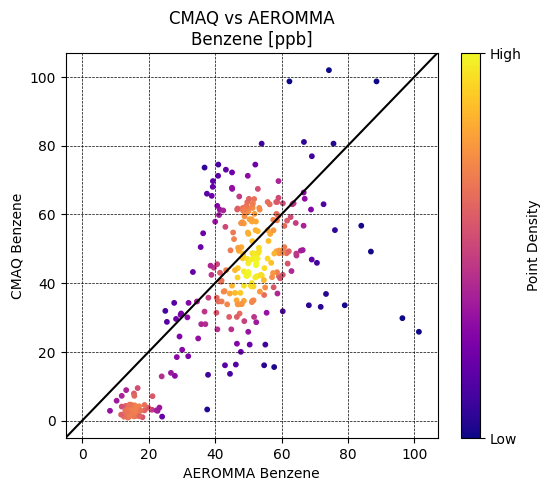

In [31]:
var_name = 'Benzene'
flight_values = aeromma_df['Benzene_NOAAPTR_ppbv'] * 1000    #converting to ppt to make point distribution easier to see
cmaq_values = cmaq_df['BEN'] * 1000000    #converting to ppt to match the units of 
var_units = 'ppb'
aeromma.compare_plot(var_name, flight_values, cmaq_values, var_units)

### Coordinate Checks
To make sure the pairing and extraction functions have worked correctly, you can try using the `aeromma.coord_checks` function, this uses a series of `aeromma.compare_plot` functions to create comparisons for each of the coordinate variables. It runs like this:

-------------------------------------------------------------------------------------------------------------
Comparison of coordinate data in AEROMMA and CMAQ for flight_20230726


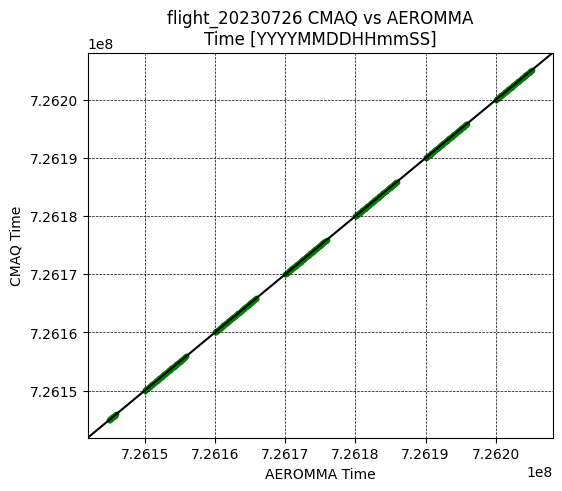

In the case of the time plot, all plots should be exactly on the line y = x. The index of every row in
the DataFrame is based on the time stamp of the AEROMMA observation so all values should match extactly
in each data set. Any variation from y = x represents a mismatch in the data and needs to be addressed.
To clarify, the label on the y-axis, "CMAQ Time", is misleading in this case because the time does not
come from CMAQ, it comes from AEROMMA.


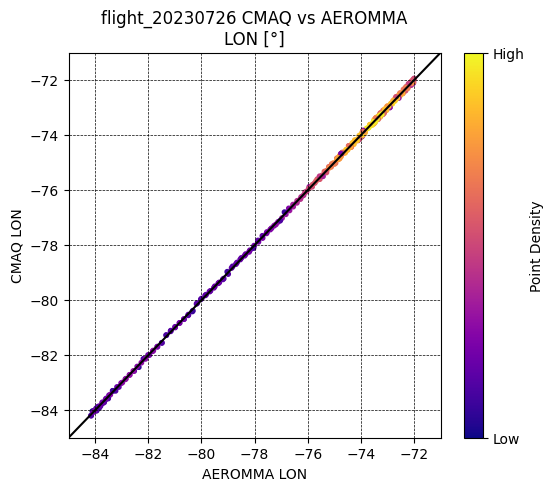

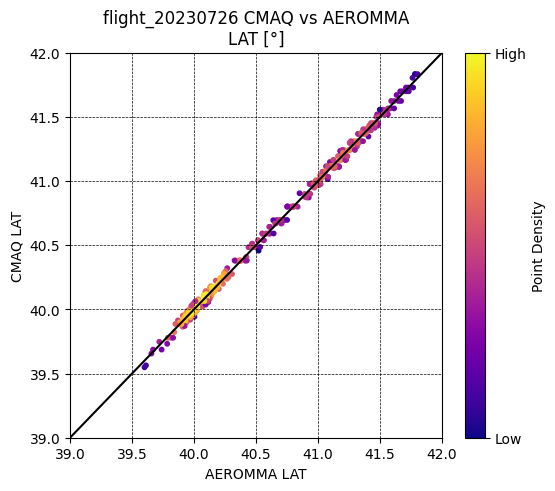

For latitude and longitude, there should be some variation aroundthe line y = x, but only slight. Any
clear deviation from the line represents a mismatch in the data.



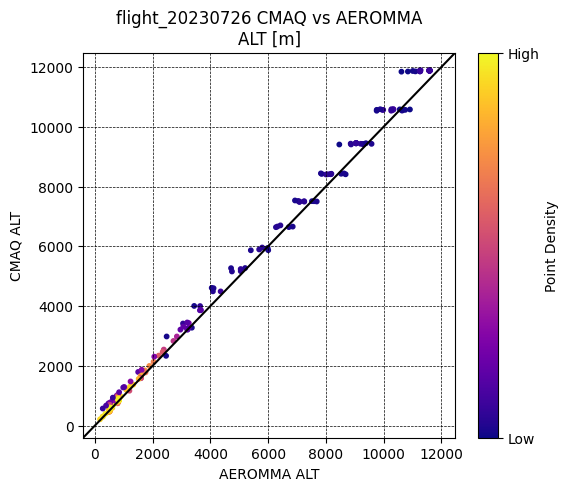

For altitude, expect some minor scatter around the line y = x, especially at higher altitudes. After a
certain altitude, the points should become spread out along lines of equal CMAQ height, representing
the grid point altitudes in the model. The values should all be in terms of height above sea level. If
a majority of values are clearly below the line y = x, there is a good chance the CMAQ extraction was
set to height above ground level. Otherwise, any other significant scatter is a sign of mismatched data.
-------------------------------------------------------------------------------------------------------------


In [32]:
aeromma.coord_checks(flight_id, cmaq_df, aeromma_df)

### Meteorological Compairson
Similar to the `aeromma.coord_checks` function, `aeromma.met_compare` is a function that is useful for understanding the accuracy of CMAQ's basic meteorological information. However, since meteorological data is neccessary to run this function, setup for it is a little more involved than for `aeromma.coord_checks`. First, extract meteorological data from CMAQ and AEROMMA:

In [33]:
#CMAQ
flight_id = aeromma.flight_id_creator(mrg_file_path)
index_file_path = 'tutorial_index_file.nc'
#cmaq_data_dir = this does not matter because when using the cmaq_output_type of 'METCRO3D', the extract_cmaq_flight_data function already knows where the domain files are stored and it will look in that directory for files
output_vars = ['PRES', 'TA']
cmaq_met_df = pair.extract_cmaq_flight_data(flight_id, index_file_path, cmaq_data_dir_path, output_vars = output_vars, cmaq_output_type = 'METCRO3D')

#AEROMMA
output_vars = ['P', 'T']
sec_met_data = aeromma.extract_flight_data(mrg_file_path, output_vars = output_vars)
clean_sec_met_data = aeromma.rm_1hz_negatives(sec_met_data)
agg_met_data = aeromma.time_agg_data(clean_sec_met_data)

#cross check data frames
cmaq_met_df, aeromma_met_df = aeromma.rm_outside_model_times(cmaq_met_df, agg_met_data)
cmaq_met_df['PRES'] = aeromma.mk_cmaq_missing(cmaq_met_df['PRES'], aeromma_met_df['P'])
cmaq_met_df['TA'] = aeromma.mk_cmaq_missing(cmaq_met_df['TA'], aeromma_met_df['T'])

Extraction of CMAQ data along trajectory of flight_20230726 complete!


Now that you have a new pair of data frames containing meteorological data, you can pass them to the `aeromma.met_compare` function to produce comparison plots for temperature and pressure. 

-------------------------------------------------------------------------------------------------------------
Comparison of coordinate data in AEROMMA and CMAQ for flight_20230726


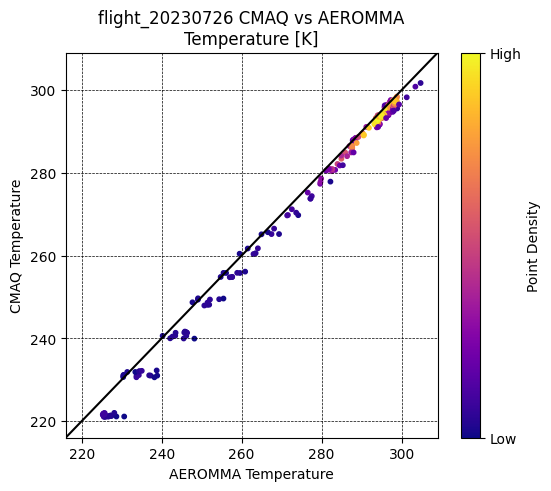

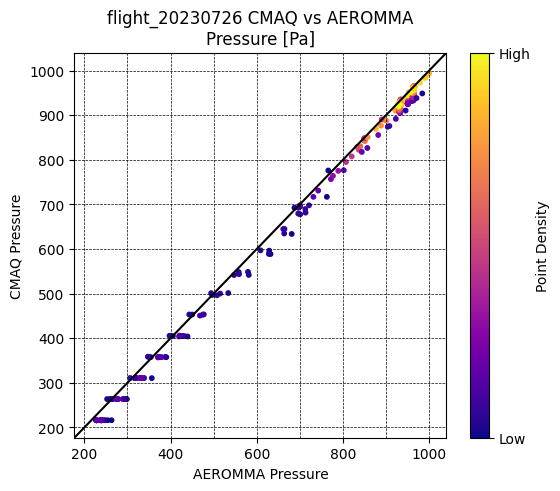

-------------------------------------------------------------------------------------------------------------


In [34]:
aeromma.met_compare(flight_id, cmaq_met_df, aeromma_met_df)

### Time series plots
At some point, you may want to look at a time series plot comparing data from CMAQ and AEROMMA over time. `aeromma.time_series` was created to allow the user to quickly generate a time series plot. To use this function, first start by using the data frame index as a time array for the x-axis. You can pull from either the CMAQ or AEROMMA data frame because if everything was done correctly, they should be identical.

In [35]:
time_array = cmaq_df.index

Once you have a time array, make a list of data frame columns you would like to include in the time series plot. In addition create a corresponding list that provides the variable name that will be used in the plot legend.

In [36]:
values_lists = [cmaq_df['BEN'] * 1000, aeromma_df['Benzene_NOAAPTR_ppbv']]    #converted CMAQ acrolein from ppm to ppb to match AEROMMA units 
var_name_list = ['CMAQ', 'AEROMMA']

The rest of the variables for `aeromma.time_series` setup are optional.

If you want to specify your own plot colors instead of using default Matplotlib colors, create another corresponding list that provides a Matplotlib color string that you would like to use for each variable. Color options can be found [here](https://matplotlib.org/stable/gallery/color/named_colors.html).

In [37]:
colors = ['r', 'k']

Then, if you want a title and y-axis label, you can specify those as well:

In [38]:
plot_title = 'CMAQ vs AEROMMA Benzene'
y_label = 'Benzene Concentration [ppb]'

Finally, you can make the time series plot using the following:

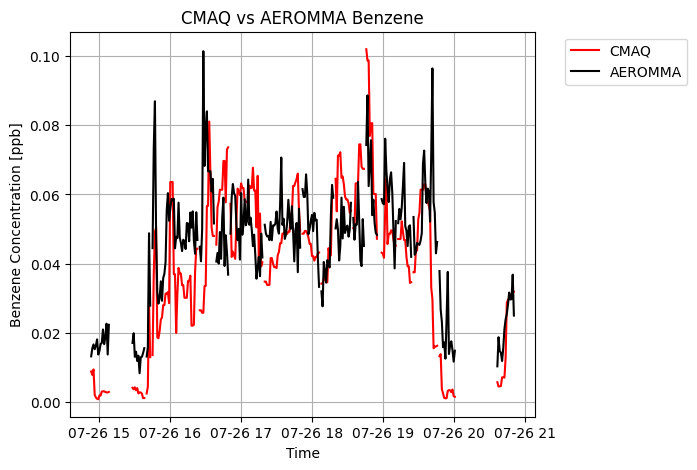

In [39]:
aeromma.time_series(time_array, values_lists, var_name_list, colors = colors, plot_title = plot_title, y_label = y_label)

### Vertical Comparison
It is sometimes useful to plot the vertical distribution of certian variables. In ordered to do this, it is important to sort each observation into a bin of observations grouped by altitude range. This can be done using the `aeromma.altitude_bins` function, which creates a new list that labels each row in the data frame by the altiude bin it fits into. By default, these bins are 500 meters each starting from sea level. That might look something like this:

In [40]:
alt_bins = aeromma.altitude_bins(cmaq_df)
list(set(alt_bins))

['0 < alt <= 500',
 '500 < alt <= 1000',
 '3000 < alt <= 3500',
 '10500 < alt <= 11000',
 '7500 < alt <= 8000',
 '9000 < alt <= 9500',
 '1500 < alt <= 2000',
 '2000 < alt <= 2500',
 '3500 < alt <= 4000',
 '5500 < alt <= 6000',
 '4000 < alt <= 4500',
 '6500 < alt <= 7000',
 '2500 < alt <= 3000',
 '7000 < alt <= 7500',
 '5000 < alt <= 5500',
 '1000 < alt <= 1500',
 '8000 < alt <= 8500',
 '4500 < alt <= 5000',
 '11500 < alt <= 12000']

Using some of the optional parameters, you can change the bins to have different widths, start at a different height other than 0 m ASL, and even create your own specialized bins with any values you like.

In [41]:
#bins generated with regular 1000 meter intervals starting at 100 m ASL
test_alt_bins = aeromma.altitude_bins(cmaq_df, bin_width = 1000, first_bin_height = 100)
list(set(test_alt_bins))

['100 < alt <= 1100',
 '2100 < alt <= 3100',
 '7100 < alt <= 8100',
 '4100 < alt <= 5100',
 '10100 < alt <= 11100',
 '6100 < alt <= 7100',
 '11100 < alt <= 12100',
 '9100 < alt <= 10100',
 '8100 < alt <= 9100',
 '5100 < alt <= 6100',
 '3100 < alt <= 4100',
 '1100 < alt <= 2100']

In [42]:
#User defined altitude bins
test_alt_bins = aeromma.altitude_bins(cmaq_df, pre_def_bins = [0, 250, 500, 750, 1000, 1500, 2000, 4000, 6000, 9000, 12000])
list(set(test_alt_bins))

['2000 < alt <= 4000',
 '1500 < alt <= 2000',
 '750 < alt <= 1000',
 '250 < alt <= 500',
 '4000 < alt <= 6000',
 '500 < alt <= 750',
 '1000 < alt <= 1500',
 '6000 < alt <= 9000',
 '0 < alt <= 250',
 '9000 < alt <= 12000']

For the purposes of this tutorial, we will stick with the default options for altitude bins.

Using the new `alt_bins` list, the vertical plot can now be created. First a few required variables need to be set up before running `aeromma.plot_vert`, the vertical plotting function. 

In [43]:
value_lists = [cmaq_df['BEN'] * 1000, aeromma_df['Benzene_NOAAPTR_ppbv']]    #CMAQ Benzene converted to ppb to match the AEROMMA units
var_names = ['CMAQ', 'AEROMMA']
colors = ['r', 'k']

In this case, `value_lists` is a list of vector-like objects that contains values of a variable that you would like to plot on the vertical plot. `var_names` is a list that corresponds to `value_lists` list and each list item is the label for one of the vectors in `value_lists` and will appear in the plot's legend. Lastly, `colors` also corresponds to `value_lists` and contains Matplotlib color strings.

You can also chose to add a plot title and an x-label:

In [44]:
plot_title = 'CMAQ vs AEROMMA Benzene'
x_label = 'Benzene Concentration [ppb]'

Now, we can make the vertical plot:

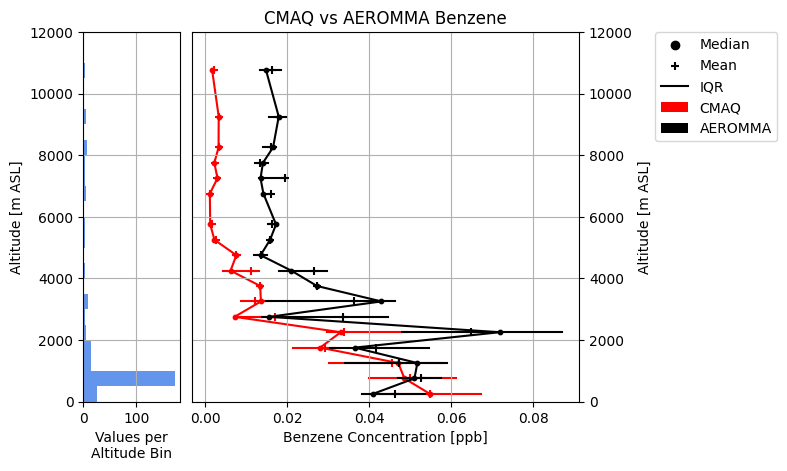

In [45]:
aeromma.plot_vert(alt_bins, value_lists, var_names, colors, x_label = x_label, title = plot_title)

### Spatial Plot
Another way to plot the data that is often used is a spatial plot to see how the data performs over an area. For this reason, `aeromma.spatial_plot` was created. All that is required to make a spatial plot using this function is a CMAQ data frame, which is needed for the latitude and longitude data for each of the plotted points, and a vector-like object containing the values you would like to plot. the values vector must have the same length as a column in the CMAQ data frame. Each point that is plotted on the resulting point represents the average value of whatever variable is used for all aircraft observations paired to a CMAQ grid point in the vertical column. 

There are also many optional parameters. One important one is `plot_type` which has options of `'diff'`, which is the default option, and `'raw'`. `'diff'` is to be used when the values set to be plot on the map represent the difference between two values, for example CMAQ Benzene - AEROMMA Benzene. `'raw'` is for times when the values plotted are just normal values, not the difference between two datasets, such as just plotting CMAQ Benzene. When making a `'diff'` plot, the colorbar that is used is hard coded and cannot be changed. When making a `'raw'` plot, although the default colorbar is `'viridis'`, this can be changed to a different colorbar using the `colorbar_name` parameter. Possible options can be found [here](https://matplotlib.org/stable/users/explain/colors/colormaps.html).

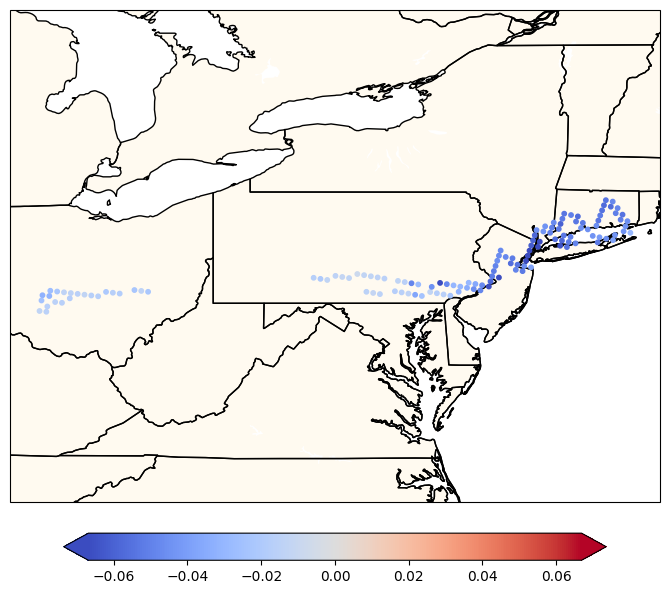

In [46]:
plot_values = cmaq_df['BEN'] - aeromma_df['Benzene_NOAAPTR_ppbv']
plot_title = 'CMAQ minus AEROMMA Benzene'
aeromma.spatial_plot(cmaq_df, plot_values, plot_title = None)

### Fire Analysis
The last function in the `aeromma_cmaq_pairing` notebook is the `function_of_hcn` function. HCN (Hydrogen Cyanide) is a mostly inert gas that is emitted in large amounts by fires. Also, it is rarely emitted by other sources. This makes HCN a great marker to determine how much a particular Aircraft observation is influenced by smoke. To help with the analysis of smoke plumes, the `function_of_hcn` function creates a scatter plot where the x-axis is the HCN concentration. This allowes the user to see if there are different groups of data based on the amount of HCN and therefore, the amount of smoke influence. 

To use the function, all you need is a vector of HCN values and a vector of values to plot on the y-axis, maybe model bias of benzene, for example. We dont currently have HCN in any of our data frames, so lets make new AEROMMA and CMAQ data frames with HCN and Benzene.

In [47]:
#if you need a reminder of what variables are available in the MERGE file, try the commented line below, the rows parameter allows you to print each variable name one line at a time. The default False just prints the whole list together 
#aeromma.list_vars(mrg_file_path, rows = True)

#extract AEROMMA HCN and Benzene data
output_vars = ['Benzene_NOAAPTR_ppbv', 'HCN_CIT']
sec_hcn_data = aeromma.extract_flight_data(mrg_file_path, output_vars = output_vars)
clean_sec_hcn_data = aeromma.rm_1hz_negatives(sec_hcn_data)
agg_hcn_data = aeromma.time_agg_data(clean_sec_hcn_data)

#CMAQ
flight_id = aeromma.flight_id_creator(mrg_file_path)
index_file_path = 'tutorial_index_file.nc'
cmaq_data_dir_path = '/work/MOD3DEV/has/2023cracmm_ages/runs/20250327cracmm3haps_base/data/output_CCTM_v55_intel23.2_2023_12US4'
output_vars = ['BEN', 'HCN']
cmaq_hcn_df = pair.extract_cmaq_flight_data(flight_id, index_file_path, cmaq_data_dir_path, output_vars = output_vars)

#cross check data frames
cmaq_hcn_df, aeromma_hcn_df = aeromma.rm_outside_model_times(cmaq_hcn_df, agg_hcn_data)
cmaq_hcn_df['BEN'] = aeromma.mk_cmaq_missing(cmaq_hcn_df['BEN'], aeromma_hcn_df['Benzene_NOAAPTR_ppbv'])
cmaq_hcn_df['HCN'] = aeromma.mk_cmaq_missing(cmaq_hcn_df['HCN'], aeromma_hcn_df['HCN_CIT'])

Extraction of CMAQ data along trajectory of flight_20230726 complete!


Now that we have the data we need, we can pass it to the `function_of_hcn` function. Lets use the AEROMMA HCN values as the x-axis values since they represent real world smoke. Also, lets include variables for the y-axis label and the plot title to make the resulting figure easier to understand. Also, unless you decide to use the default HCN units of `'ppt'`, make sure to change the `hcn_units` parameter to a string of your choice, preferably one that represents the HCN units.

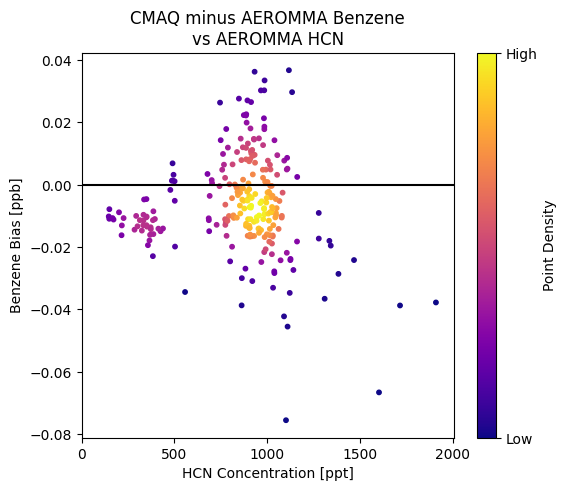

In [48]:
benzene_bias = (cmaq_hcn_df['BEN'] * 1000) - aeromma_hcn_df['Benzene_NOAAPTR_ppbv']    #converted CMAQ benzene from units of ppm to ppb to match the AEROMMA units
hcn_values = aeromma_hcn_df['HCN_CIT']
y_label = 'Benzene Bias [ppb]'
plot_title = 'CMAQ minus AEROMMA Benzene\nvs AEROMMA HCN'
aeromma.function_of_hcn(hcn_values, benzene_bias, y_label = y_label, title = plot_title)